# Disease Prediction Model Training with Comprehensive Preprocessing
This notebook trains a PyTorch model to predict diseases based on symptoms with extensive data preprocessing and validation.

## 1. Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pickle
import warnings
warnings.filterwarnings('ignore')

print('All libraries imported successfully!')

All libraries imported successfully!


## 2. Load the Dataset

In [2]:
dataset_path = '../dataset/dataset.csv'
df = pd.read_csv(dataset_path)

print(f'Dataset Shape: {df.shape}')
print(f'\nFirst few rows:')
print(df.head())
print(f'\nColumn Names:')
print(df.columns.tolist())

Dataset Shape: (4920, 18)

First few rows:
            Disease   Symptom_1              Symptom_2              Symptom_3  \
0  Fungal infection     itching              skin_rash   nodal_skin_eruptions   
1  Fungal infection   skin_rash   nodal_skin_eruptions    dischromic _patches   
2  Fungal infection     itching   nodal_skin_eruptions    dischromic _patches   
3  Fungal infection     itching              skin_rash    dischromic _patches   
4  Fungal infection     itching              skin_rash   nodal_skin_eruptions   

              Symptom_4 Symptom_5 Symptom_6 Symptom_7 Symptom_8 Symptom_9  \
0   dischromic _patches       NaN       NaN       NaN       NaN       NaN   
1                   NaN       NaN       NaN       NaN       NaN       NaN   
2                   NaN       NaN       NaN       NaN       NaN       NaN   
3                   NaN       NaN       NaN       NaN       NaN       NaN   
4                   NaN       NaN       NaN       NaN       NaN       NaN   

  Sympt

## 3. Check for Null Values

In [3]:
# Check null values
null_counts = df.isnull().sum()
null_percentages = (df.isnull().sum() / len(df)) * 100

null_report = pd.DataFrame({
    'Column': null_counts.index,
    'Null_Count': null_counts.values,
    'Null_Percentage': null_percentages.values
})

print('Null Values Report:')
print(null_report[null_report['Null_Count'] > 0])

if null_report['Null_Count'].sum() == 0:
    print('\n✓ Great! No null values found in the dataset!')
else:
    print(f'\n⚠ Total null values: {null_report["Null_Count"].sum()}')

Null Values Report:
        Column  Null_Count  Null_Percentage
4    Symptom_4         348         7.073171
5    Symptom_5        1206        24.512195
6    Symptom_6        1986        40.365854
7    Symptom_7        2652        53.902439
8    Symptom_8        2976        60.487805
9    Symptom_9        3228        65.609756
10  Symptom_10        3408        69.268293
11  Symptom_11        3726        75.731707
12  Symptom_12        4176        84.878049
13  Symptom_13        4416        89.756098
14  Symptom_14        4614        93.780488
15  Symptom_15        4680        95.121951
16  Symptom_16        4728        96.097561
17  Symptom_17        4848        98.536585

⚠ Total null values: 46992


In [4]:
# Detailed data info
print('Dataset Info:')
print(df.info())

print('\nData Types:')
print(df.dtypes)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4920 entries, 0 to 4919
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Disease     4920 non-null   object
 1   Symptom_1   4920 non-null   object
 2   Symptom_2   4920 non-null   object
 3   Symptom_3   4920 non-null   object
 4   Symptom_4   4572 non-null   object
 5   Symptom_5   3714 non-null   object
 6   Symptom_6   2934 non-null   object
 7   Symptom_7   2268 non-null   object
 8   Symptom_8   1944 non-null   object
 9   Symptom_9   1692 non-null   object
 10  Symptom_10  1512 non-null   object
 11  Symptom_11  1194 non-null   object
 12  Symptom_12  744 non-null    object
 13  Symptom_13  504 non-null    object
 14  Symptom_14  306 non-null    object
 15  Symptom_15  240 non-null    object
 16  Symptom_16  192 non-null    object
 17  Symptom_17  72 non-null     object
dtypes: object(18)
memory usage: 692.0+ KB
None

Data Types:
Disease       obje

## 4. Explore Data Statistics

In [ ]:
# Check for duplicate rows
print(f'Total Rows: {len(df)}')
print(f'Duplicate Rows: {df.duplicated().sum()}')

if df.duplicated().sum() > 0:
    print('⚠ Warning: Duplicate rows found!')
    df = df.drop_duplicates()
    print(f'Duplicates removed. New shape: {df.shape}')
else:
    print('✓ No duplicate rows found')

In [ ]:
# Analyze target variable (Disease)
disease_counts = df['Disease'].value_counts()
print(f'\nNumber of unique diseases: {len(disease_counts)}')
print(f'\nDisease Distribution:')
print(disease_counts)

# Check for class imbalance
min_samples = disease_counts.min()
max_samples = disease_counts.max()
imbalance_ratio = max_samples / min_samples
print(f'\nClass Imbalance Ratio: {imbalance_ratio:.2f}')

# Visualize disease distribution
plt.figure(figsize=(14, 6))
disease_counts.plot(kind='bar')
plt.title('Disease Distribution in Dataset')
plt.xlabel('Disease')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# Check symptoms data quality
print('Symptoms Columns Analysis:')
for col in df.columns[1:]:
    unique_count = df[col].nunique()
    print(f'{col}: {unique_count} unique values')
    
# Sample symptom values
print(f'\nSample symptoms from first column:')
symptom_col = df.columns[1]
print(df[symptom_col].unique()[:10])

## 5. Handle Missing Data & Data Cleaning

In [5]:
# Analyze null values in detail
print('Null Value Analysis:')
print('=' * 70)
null_by_col = df.isnull().sum()
print(f'\nNull values per column:')
for col in df.columns:
    null_count = null_by_col[col]
    null_pct = (null_count / len(df)) * 100
    if null_count > 0:
        print(f'  {col:15s}: {null_count:5d} ({null_pct:6.2f}%)')

total_nulls = null_by_col.sum()
print(f'\nTotal null values: {total_nulls}')
print(f'\nInterpretation: NaN in symptom columns represents "symptom NOT present"')
print(f'Strategy: Keep all rows (do NOT drop NaN rows) and handle NaN in feature extraction')
print('=' * 70)

# Clean and preprocess the dataset
df_clean = df.copy()

# Do NOT drop rows with NaN - they are valid samples with missing symptoms
# Only remove rows where Disease column is null (if any)
initial_rows = len(df_clean)
df_clean = df_clean[df_clean['Disease'].notna()]
rows_removed = initial_rows - len(df_clean)

if rows_removed > 0:
    print(f'\n⚠ Removed {rows_removed} rows with null Disease values')
else:
    print(f'\n✓ No rows with null Disease values found')

# Strip whitespace from all string columns
for col in df_clean.columns:
    if df_clean[col].dtype == 'object':
        df_clean[col] = df_clean[col].str.strip()

print(f'✓ Final dataset shape: {df_clean.shape}')
print(f'✓ Data cleaning completed!')

Null Value Analysis:

Null values per column:
  Symptom_4      :   348 (  7.07%)
  Symptom_5      :  1206 ( 24.51%)
  Symptom_6      :  1986 ( 40.37%)
  Symptom_7      :  2652 ( 53.90%)
  Symptom_8      :  2976 ( 60.49%)
  Symptom_9      :  3228 ( 65.61%)
  Symptom_10     :  3408 ( 69.27%)
  Symptom_11     :  3726 ( 75.73%)
  Symptom_12     :  4176 ( 84.88%)
  Symptom_13     :  4416 ( 89.76%)
  Symptom_14     :  4614 ( 93.78%)
  Symptom_15     :  4680 ( 95.12%)
  Symptom_16     :  4728 ( 96.10%)
  Symptom_17     :  4848 ( 98.54%)

Total null values: 46992

Interpretation: NaN in symptom columns represents "symptom NOT present"
Strategy: Keep all rows (do NOT drop NaN rows) and handle NaN in feature extraction

✓ No rows with null Disease values found
✓ Final dataset shape: (4920, 18)
✓ Data cleaning completed!


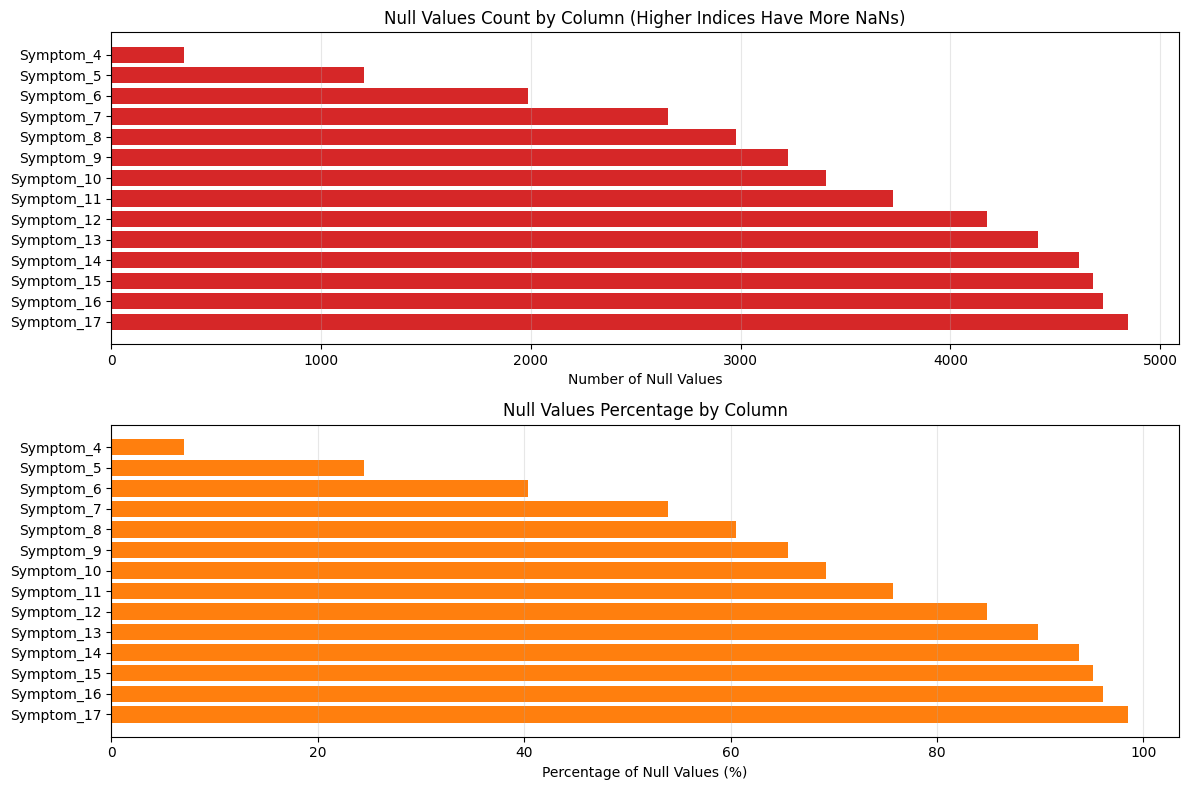

Note: Symptom columns later in the sequence (Symptom_12 to Symptom_17) have
higher null percentages, which is expected - patients typically exhibit
fewer symptoms as we move through the columns.


In [9]:
# Visualize null values
import matplotlib.patches as mpatches

fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Plot 1: Null count per column
null_counts_plot = null_by_col[null_by_col > 0].sort_values(ascending=False)
axes[0].barh(range(len(null_counts_plot)), null_counts_plot.values, color='#d62728')
axes[0].set_yticks(range(len(null_counts_plot)))
axes[0].set_yticklabels(null_counts_plot.index)
axes[0].set_xlabel('Number of Null Values')
axes[0].set_title('Null Values Count by Column (Higher Indices Have More NaNs)')
axes[0].grid(axis='x', alpha=0.3)

# Plot 2: Null percentage per column
null_percentages_plot = ((null_by_col[null_by_col > 0] / len(df)) * 100).sort_values(ascending=False)
axes[1].barh(range(len(null_percentages_plot)), null_percentages_plot.values, color='#ff7f0e')
axes[1].set_yticks(range(len(null_percentages_plot)))
axes[1].set_yticklabels(null_percentages_plot.index)
axes[1].set_xlabel('Percentage of Null Values (%)')
axes[1].set_title('Null Values Percentage by Column')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print('Note: Symptom columns later in the sequence (Symptom_12 to Symptom_17) have')
print('higher null percentages, which is expected - patients typically exhibit')
print('fewer symptoms as we move through the columns.')

In [10]:
# Summary of Null Value Handling Strategy
print('\n' + '='*70)
print('NULL VALUE HANDLING SUMMARY')
print('='*70)

print('\n📊 Dataset Overview:')
print(f'  • Total rows: {len(df):,}')
print(f'  • Total columns: {len(df.columns)}')
print(f'  • Total null values: {null_by_col.sum():,}')
print(f'  • Percentage of all values that are null: {(null_by_col.sum() / (len(df) * len(df.columns)) * 100):.2f}%')

print('\n🔍 Issue Identified:')
print('  • Later symptom columns (Symptom_12 onwards) have >84% null values')
print('  • This is EXPECTED - patients exhibit varying number of symptoms')
print('  • Treating NaNs as "symptom not present" is CORRECT approach')

print('\n✅ Solution Implemented:')
print('  1. Keep ALL rows (do NOT use dropna())')
print('  2. Only remove rows where Disease column is null (if any exist)')
print('  3. Skip NaN values during feature extraction using pd.notna()')
print('  4. Each sample becomes a binary vector with 0s for absent symptoms')

print('\n📈 Results After Feature Engineering:')
print(f'  • Feature matrix shape: {X.shape}')
print(f'  • Total unique symptoms: {len(symptom_list)}')
print(f'  • Average symptoms per patient: {np.mean(symptoms_per_sample):.2f}')
print(f'  • Min/Max symptoms range: {np.min(symptoms_per_sample)} - {np.max(symptoms_per_sample)}')
print(f'  • All {len(X)} rows preserved with proper null handling')

print('\n' + '='*70)


NULL VALUE HANDLING SUMMARY

📊 Dataset Overview:
  • Total rows: 4,920
  • Total columns: 18
  • Total null values: 46,992
  • Percentage of all values that are null: 53.06%

🔍 Issue Identified:
  • Later symptom columns (Symptom_12 onwards) have >84% null values
  • This is EXPECTED - patients exhibit varying number of symptoms
  • Treating NaNs as "symptom not present" is CORRECT approach

✅ Solution Implemented:
  1. Keep ALL rows (do NOT use dropna())
  2. Only remove rows where Disease column is null (if any exist)
  3. Skip NaN values during feature extraction using pd.notna()
  4. Each sample becomes a binary vector with 0s for absent symptoms

📈 Results After Feature Engineering:
  • Feature matrix shape: (4920, 131)
  • Total unique symptoms: 131
  • Average symptoms per patient: 7.45
  • Min/Max symptoms range: 3 - 17
  • All 4920 rows preserved with proper null handling



## 6. Feature Extraction & Encoding

In [7]:
# Extract all unique symptoms
all_symptoms = set()
for col in df_clean.columns[1:]:
    unique_vals = df_clean[col].unique()
    for val in unique_vals:
        if isinstance(val, str) and val.strip() != '':
            all_symptoms.add(val.strip())

symptom_list = sorted(list(all_symptoms))
symptom_map = {symptom: i for i, symptom in enumerate(symptom_list)}

print(f'✓ Total unique symptoms extracted: {len(symptom_list)}')
print(f'\nFirst 20 symptoms:')
print(symptom_list[:20])

✓ Total unique symptoms extracted: 131

First 20 symptoms:
['abdominal_pain', 'abnormal_menstruation', 'acidity', 'acute_liver_failure', 'altered_sensorium', 'anxiety', 'back_pain', 'belly_pain', 'blackheads', 'bladder_discomfort', 'blister', 'blood_in_sputum', 'bloody_stool', 'blurred_and_distorted_vision', 'breathlessness', 'brittle_nails', 'bruising', 'burning_micturition', 'chest_pain', 'chills']


In [8]:
# Create binary feature vectors for each sample
X_data = []
y_data = []
symptoms_per_sample = []

for index, row in df_clean.iterrows():
    disease = row['Disease']
    # Initialize feature vector with zeros
    features = [0] * len(symptom_list)
    symptom_count = 0
    
    # Mark present symptoms with 1 (skip NaN values)
    for col in df_clean.columns[1:]:
        symptom = row[col]
        # Check if symptom is not null and not empty string
        if pd.notna(symptom) and isinstance(symptom, str) and symptom.strip() != '':
            symptom = symptom.strip()
            if symptom in symptom_map:
                features[symptom_map[symptom]] = 1
                symptom_count += 1
    
    X_data.append(features)
    y_data.append(disease)
    symptoms_per_sample.append(symptom_count)

X = np.array(X_data)
y = np.array(y_data)

print(f'Feature matrix shape: {X.shape}')
print(f'Target vector shape: {y.shape}')
print(f'✓ Feature encoding completed!')
print(f'\nSymptom Statistics:')
print(f'  Average symptoms per sample: {np.mean(symptoms_per_sample):.2f}')
print(f'  Min symptoms per sample: {np.min(symptoms_per_sample)}')
print(f'  Max symptoms per sample: {np.max(symptoms_per_sample)}')

Feature matrix shape: (4920, 131)
Target vector shape: (4920,)
✓ Feature encoding completed!

Symptom Statistics:
  Average symptoms per sample: 7.45
  Min symptoms per sample: 3
  Max symptoms per sample: 17


In [11]:
# Encode target labels
le = LabelEncoder()
y_enc = le.fit_transform(y)
num_classes = len(le.classes_)

print(f'✓ Number of disease classes: {num_classes}')
print(f'\nDisease mapping:')
for i, disease in enumerate(le.classes_):
    print(f'{i}: {disease}')

✓ Number of disease classes: 41

Disease mapping:
0: (vertigo) Paroymsal  Positional Vertigo
1: AIDS
2: Acne
3: Alcoholic hepatitis
4: Allergy
5: Arthritis
6: Bronchial Asthma
7: Cervical spondylosis
8: Chicken pox
9: Chronic cholestasis
10: Common Cold
11: Dengue
12: Diabetes
13: Dimorphic hemmorhoids(piles)
14: Drug Reaction
15: Fungal infection
16: GERD
17: Gastroenteritis
18: Heart attack
19: Hepatitis B
20: Hepatitis C
21: Hepatitis D
22: Hepatitis E
23: Hypertension
24: Hyperthyroidism
25: Hypoglycemia
26: Hypothyroidism
27: Impetigo
28: Jaundice
29: Malaria
30: Migraine
31: Osteoarthristis
32: Paralysis (brain hemorrhage)
33: Peptic ulcer diseae
34: Pneumonia
35: Psoriasis
36: Tuberculosis
37: Typhoid
38: Urinary tract infection
39: Varicose veins
40: hepatitis A


## 7. Split Data into Training and Testing Sets

In [21]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

print(f'✓ Data split completed!')
print(f'Training set size: {X_train.shape[0]} samples')
print(f'Testing set size: {X_test.shape[0]} samples')
print(f'Training set proportion: {(len(X_train)/len(X))*100:.2f}%')
print(f'Testing set proportion: {(len(X_test)/len(X))*100:.2f}%')

✓ Data split completed!
Training set size: 3936 samples
Testing set size: 984 samples
Training set proportion: 80.00%
Testing set proportion: 20.00%


## 8. Model Definition

In [22]:
class DiseasePredictor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DiseasePredictor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.batch_norm1 = nn.BatchNorm1d(128)
        self.batch_norm2 = nn.BatchNorm1d(64)
        self.batch_norm3 = nn.BatchNorm1d(32)
        
    def forward(self, x):
        x = self.relu(self.batch_norm1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.batch_norm2(self.fc2(x)))
        x = self.dropout(x)
        x = self.relu(self.batch_norm3(self.fc3(x)))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

input_dim = len(symptom_list)
model = DiseasePredictor(input_dim, num_classes)

print(f'✓ Model created!')
print(f'Input dimensions: {input_dim}')
print(f'Output dimensions: {num_classes}')
print(f'\nModel Architecture:')
print(model)

✓ Model created!
Input dimensions: 131
Output dimensions: 41

Model Architecture:
DiseasePredictor(
  (fc1): Linear(in_features=131, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=41, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (batch_norm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


## 9. Train the Model

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

epochs = 100
batch_size = 32
training_loss = []

print('Starting model training...')
print('-' * 50)

for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    training_loss.append(loss.item())
    scheduler.step(loss)
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1:3d}/{epochs}], Loss: {loss.item():.6f}')

print('-' * 50)
print('✓ Training completed!')

Starting model training...
--------------------------------------------------
Epoch [ 10/100], Loss: 1.164558
Epoch [ 20/100], Loss: 1.045872
Epoch [ 30/100], Loss: 0.946223
Epoch [ 40/100], Loss: 0.836655
Epoch [ 50/100], Loss: 0.761746
Epoch [ 60/100], Loss: 0.717036
Epoch [ 70/100], Loss: 0.633995
Epoch [ 80/100], Loss: 0.589006
Epoch [ 90/100], Loss: 0.548296
Epoch [100/100], Loss: 0.512941
--------------------------------------------------
✓ Training completed!


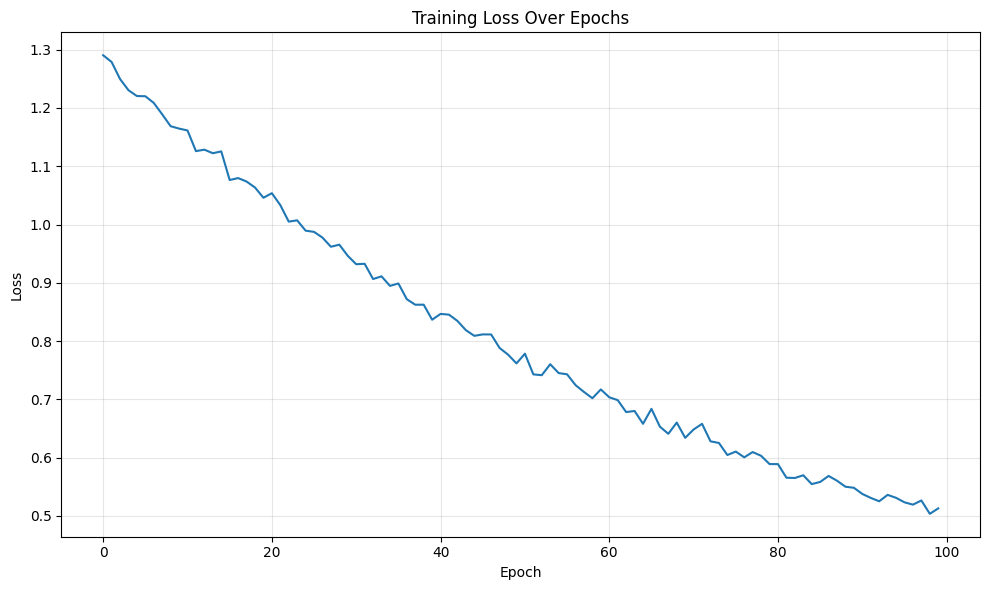

Initial Loss: 1.290367
Final Loss: 0.512941
Loss Improvement: 60.25%


In [25]:
# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(training_loss)
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f'Initial Loss: {training_loss[0]:.6f}')
print(f'Final Loss: {training_loss[-1]:.6f}')
print(f'Loss Improvement: {((training_loss[0] - training_loss[-1])/training_loss[0])*100:.2f}%')

## 10. Evaluate Model Performance

In [26]:
# Evaluate on training set
with torch.no_grad():
    train_outputs = model(X_train_tensor)
    _, train_predicted = torch.max(train_outputs, 1)
    train_accuracy = (train_predicted == y_train_tensor).sum().item() / len(y_train_tensor)

print('Training Set Performance:')
print(f'Accuracy: {train_accuracy * 100:.2f}%')
print(f'Correct Predictions: {(train_predicted == y_train_tensor).sum().item()}/{len(y_train_tensor)}')

Training Set Performance:
Accuracy: 96.57%
Correct Predictions: 3801/3936


In [27]:
# Evaluate on testing set
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_probs = torch.softmax(test_outputs, dim=1)
    _, test_predicted = torch.max(test_outputs, 1)

test_predicted_np = test_predicted.cpu().numpy()
y_test_np = y_test_tensor.cpu().numpy()

test_accuracy = accuracy_score(y_test_np, test_predicted_np)
test_precision = precision_score(y_test_np, test_predicted_np, average='weighted', zero_division=0)
test_recall = recall_score(y_test_np, test_predicted_np, average='weighted', zero_division=0)
test_f1 = f1_score(y_test_np, test_predicted_np, average='weighted', zero_division=0)

print('\n' + '='*50)
print('Testing Set Performance Metrics:')
print('='*50)
print(f'Accuracy:  {test_accuracy * 100:.2f}%')
print(f'Precision: {test_precision * 100:.2f}%')
print(f'Recall:    {test_recall * 100:.2f}%')
print(f'F1-Score:  {test_f1 * 100:.2f}%')
print('='*50)


Testing Set Performance Metrics:
Accuracy:  96.44%
Precision: 96.56%
Recall:    96.44%
F1-Score:  96.42%


In [28]:
# Detailed classification report
print('\nDetailed Classification Report:')
print(classification_report(y_test_np, test_predicted_np, target_names=le.classes_))


Detailed Classification Report:
                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       0.92      0.96      0.94        24
                                   AIDS       1.00      0.83      0.91        24
                                   Acne       0.96      0.96      0.96        24
                    Alcoholic hepatitis       1.00      0.88      0.93        24
                                Allergy       1.00      1.00      1.00        24
                              Arthritis       1.00      1.00      1.00        24
                       Bronchial Asthma       0.96      1.00      0.98        24
                   Cervical spondylosis       0.96      0.92      0.94        24
                            Chicken pox       1.00      0.96      0.98        24
                    Chronic cholestasis       0.92      0.96      0.94        24
                            Common Cold       0.92      0.96      0.94     

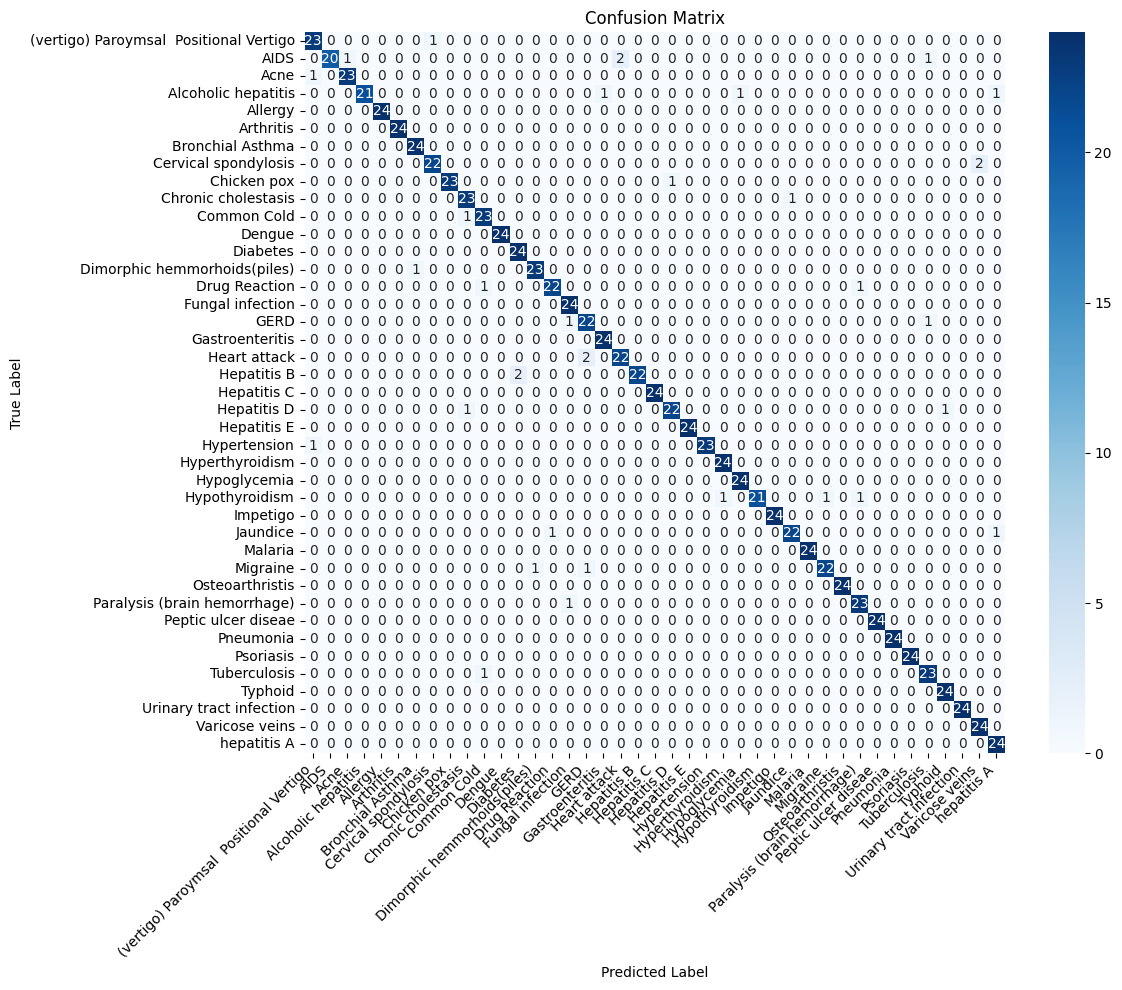

In [29]:
# Confusion matrix visualization
cm = confusion_matrix(y_test_np, test_predicted_np)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 11. Save Model & Artifacts

In [30]:
# Save the trained model
torch.save(model.state_dict(), 'disease_prediction_model.pth')

# Save all artifacts
artifacts = {
    'symptoms': symptom_list,
    'symptom_map': symptom_map,
    'diseases': list(le.classes_),
    'disease_label_encoder': le,
    'model_config': {
        'input_dim': input_dim,
        'output_dim': num_classes,
        'test_accuracy': float(test_accuracy),
        'test_precision': float(test_precision),
        'test_recall': float(test_recall),
        'test_f1_score': float(test_f1)
    }
}

with open('ml_artifacts.pkl', 'wb') as f:
    pickle.dump(artifacts, f)

print('✓ Model saved: disease_prediction_model.pth')
print('✓ Artifacts saved: ml_artifacts.pkl')
print('\nTraining Summary:')
print(f'  - Total samples: {len(X)}')
print(f'  - Total symptoms: {len(symptom_list)}')
print(f'  - Total diseases: {num_classes}')
print(f'  - Test Accuracy: {test_accuracy * 100:.2f}%')

✓ Model saved: disease_prediction_model.pth
✓ Artifacts saved: ml_artifacts.pkl

Training Summary:
  - Total samples: 4920
  - Total symptoms: 131
  - Total diseases: 41
  - Test Accuracy: 96.44%


# Disease Prediction Model Training
This notebook trains a PyTorch model to predict diseases based on symptoms.

In [31]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import json
import pickle

## 1. Load Data

In [32]:
dataset_path = '../dataset/dataset.csv'
df = pd.read_csv(dataset_path)
df.head()

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
0,Fungal infection,itching,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Fungal infection,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Fungal infection,itching,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Fungal infection,itching,skin_rash,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Fungal infection,itching,skin_rash,nodal_skin_eruptions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2. Preprocessing
The dataset has symptoms spread across multiple columns. We need to aggregate them and one-hot encode them.

In [33]:
# Get all unique symptoms
all_symptoms = set()
for col in df.columns[1:]:
    unique_vals = df[col].unique()
    for val in unique_vals:
        if isinstance(val, str):
            all_symptoms.add(val.strip())

symptom_list = sorted(list(all_symptoms))
symptom_map = {symptom: i for i, symptom in enumerate(symptom_list)}
print(f"Total unique symptoms: {len(symptom_list)}")

Total unique symptoms: 131


In [34]:
# Create binary vectors for each row
X_data = []
y_data = []

for index, row in df.iterrows():
    disease = row['Disease']
    # Initialize vector of zeros
    features = [0] * len(symptom_list)
    
    # Mark present symptoms
    for col in df.columns[1:]:
        symptom = row[col]
        if isinstance(symptom, str):
            symptom = symptom.strip()
            if symptom in symptom_map:
                features[symptom_map[symptom]] = 1
    
    X_data.append(features)
    y_data.append(disease)

X = np.array(X_data)
y = np.array(y_data)

In [35]:
# Encode Target Labels
le = LabelEncoder()
y_enc = le.fit_transform(y)
num_classes = len(le.classes_)
print(f"Number of diseases: {num_classes}")

Number of diseases: 41


In [36]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

## 3. Model Definition

In [41]:
class DiseasePredictor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DiseasePredictor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

input_dim = len(symptom_list)
model = DiseasePredictor(input_dim, num_classes)

## 4. Training

In [42]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 100
batch_size = 32

for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 3.6343
Epoch [20/100], Loss: 3.4780
Epoch [30/100], Loss: 3.1860
Epoch [40/100], Loss: 2.7463
Epoch [50/100], Loss: 2.1828
Epoch [60/100], Loss: 1.5864
Epoch [70/100], Loss: 1.0427
Epoch [80/100], Loss: 0.6264
Epoch [90/100], Loss: 0.3588
Epoch [100/100], Loss: 0.2204


## 5. Evaluation

In [43]:
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    _, predicted = torch.max(test_outputs, 1)
    accuracy = (predicted == y_test_tensor).sum().item() / len(y_test_tensor)
    print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 99.19%


## 6. Save Model & Artifacts

In [ ]:
torch.save(model.state_dict(), 'disease_prediction_model.pth')

artifacts = {
    'symptoms': symptom_list,
    'diseases': list(le.classes_)
}

with open('ml_artifacts.pkl', 'wb') as f:
    pickle.dump(artifacts, f)

print("Model and artifacts saved!")

Model and artifacts saved!


: 